## Credit to https://github.com/johnnyf-hcp/vault-demo-mongodb/blob/main/vault-demo-kmip-mongdb-tde.ipynb

In [ ]:
%env WORKDIR=/tmp/vault
%env VAULT_KMIP_PORT=5696
%env MONGODB_PORT=27017

In [ ]:
%%bash
cat $WORKDIR/VAULT_TOKEN.TXT
cat $WORKDIR/VAULT_ADDR.TXT

In [ ]:
%env VAULT_ADDR=https://vault-primary-europe-southwest1-rche.josemerchan-f986bf.gcp.sbx.hashicorpdemo.com:8200
%env VAULT_TOKEN=hvs.TOQpapl9gf4vE5R68194BK6k

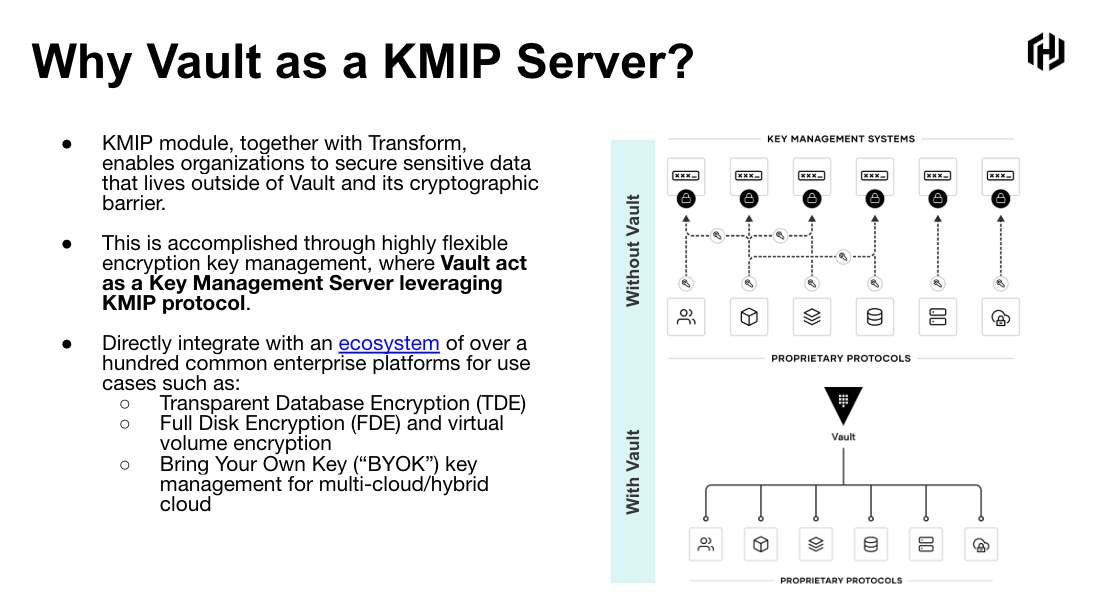

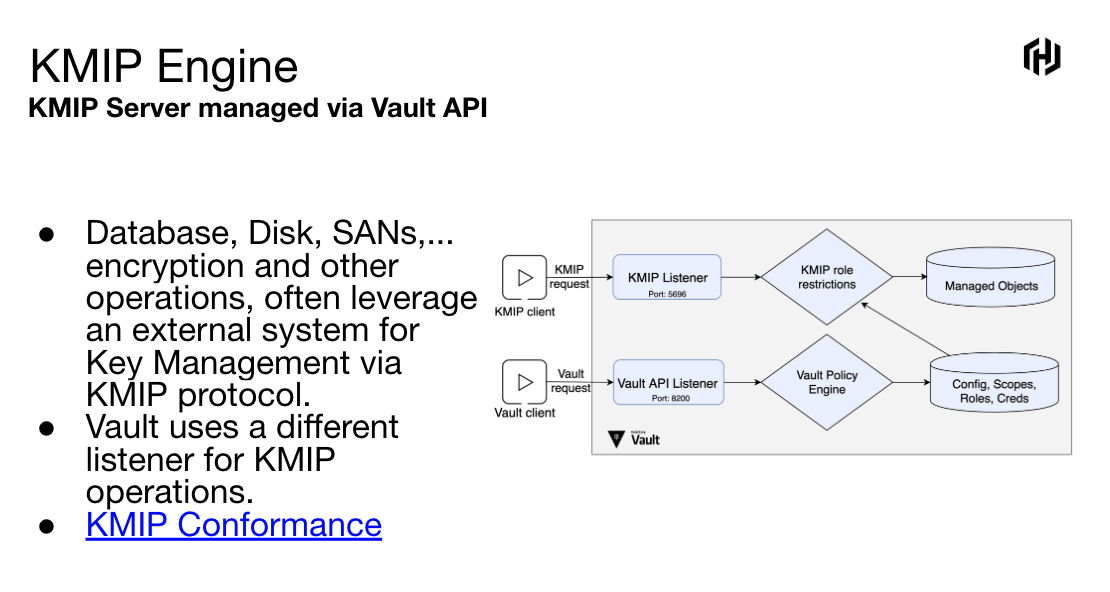

# MongoDB Enterprise without Encryption at Rest

Setup a demo MongoDB server.  Show that data stored is unencrypted by default.

### Show the contents of MongoDB database data folder

In [ ]:
%%bash
export POD=$(kubectl get pods -n mongodb -l app=mongodb -o jsonpath='{.items[0].metadata.name}')
kubectl exec -i -t -n mongodb $POD -- ls /data/db

### Create database “record”, insert record with random user details (using function makeid), and display table records

In [ ]:
%%bash
# Create database “record”, insert record with random user details (using function makeid), and display table records
# Note: You can run this multiple times to insert more records as required
export MONGODB_ADDR=$(kubectl get svc -n mongodb mongodb -o json | jq -r '.status.loadBalancer.ingress[0].ip')
export USERNAME=mdbadmin
export PASSWORD=Passw0rd123!

mongosh -u "${USERNAME}" -p "${PASSWORD}" "mongodb://${MONGODB_ADDR}/admin" \
--eval "use record" \
--eval "function makeid(length) {
    var result = '';
    var characters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789';
    for (var i = 0; i < length; i++) {
        result += characters.charAt(Math.floor(Math.random() * characters.length));
    }
    return result;
}" \
--eval "db.users.insertOne({username: 'user-' + makeid(4), password: makeid(20)})" \
--eval "db.users.find()"


### Flush all data to the storage layer

In [ ]:
%%bash
export MONGODB_ADDR=$(kubectl get svc -n mongodb mongodb -o json | jq -r '.status.loadBalancer.ingress[0].ip')
export USERNAME=mdbadmin
export PASSWORD=Passw0rd123!


# Take note of the username and password values being inserted into the table
mongosh -u "$USERNAME" -p "$PASSWORD" "mongodb://${MONGODB_ADDR}/admin" --eval "db.adminCommand( { fsync: 1 } )"

### Now view the contents of MongoDB database data folder again.  You should notice a new collection file for the data we inserted. 
### It should be named like "collection-7--XXXXXXXXXXXXXXXXXX.wt" collection-7--4848515339651436823.wt 

In [ ]:
%%bash
# Now view the contents of MongoDB database data folder again.  You should notice a new collection file for the data we inserted. 
# It should be named like "collection-7--XXXXXXXXXXXXXXXXXX.wt" collection-7--4848515339651436823.wt 
export POD=$(kubectl get pods -n mongodb -l app=mongodb -o jsonpath='{.items[0].metadata.name}')
# Show the contents of MongoDB database data folder
echo "All Files"
kubectl exec -i -t -n mongodb $POD -- ls /data/db 

In [ ]:
%%bash
export POD=$(kubectl get pods -n mongodb -l app=mongodb -o jsonpath='{.items[0].metadata.name}')
# Show the contents of MongoDB database data folder
echo "Filtering for collection-7-XXXXXXXXXXXXXXXXXX.wt"
kubectl exec -i -t -n mongodb $POD  -- ls /data/db | grep "collection-7"

In [ ]:
## In a terminal 
# Show the contents of MongoDB database data folder
# Dump the contents of the new collections file.
# Notice that the username and password of the inserted record can be seen in clear text
# Note: MongoDB might take a while to flush the data to the database file.  Wait a while and try again if you do not see any data in the file.
export POD=$(kubectl get pods -n mongodb -l app=mongodb -o jsonpath='{.items[0].metadata.name}')
kubectl exec -i -t -n mongodb $POD  -- sh -c "cat /data/db/collection-7-*" 

# MongoDB Enterprise with Encryption at Rest with Vault KMIP Engine

This section demonstrates the configuration of MongoDB Enterprise with Encryption at Rest with HashiCorp's Vault KMIP secrets engine.

Ref:
- https://developer.hashicorp.com/vault/docs/secrets/kmip
- https://developer.hashicorp.com/vault/tutorials/adp/kmip-engine

## Step 1 - Enable Vault KMIP Engine

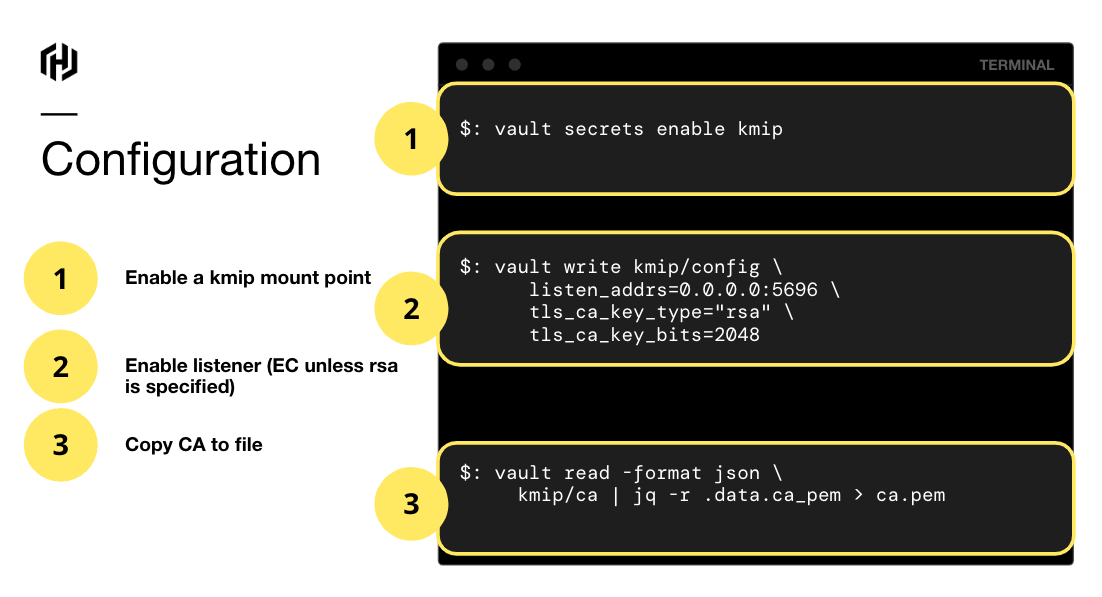

In [ ]:
%%bash
# Enable KMIP secrets engine at the default mount path
vault secrets enable kmip

### Start KMIP Server and set client TLS certificate TTL to 365 days

In [ ]:
%%bash
export KMIP_ADDR=$(terraform  output -state=../1_Platform_Deployment/terraform.tfstate -raw cluster_primary_fqdn_kmip)
export FQDN=$(echo "$KMIP_ADDR" | sed -E 's~https://([^:/]+).*~\1~')
export IP=$(dig $FQDN +short)

# Option 1 - Elliptic Curve (EC) is the default
vault write kmip/config listen_addrs=0.0.0.0 default_tls_client_ttl=365d server_hostnames=$FQDN,localhost server_ips=$IP,127.0.0.1
# Option 2 - RSA
#vault write kmip/config listen_addrs=0.0.0.0:$VAULT_KMIP_PORT tls_ca_key_type="rsa" tls_ca_key_bits=2048 default_tls_client_ttl=365d server_hostnames=$VAULT_IP,localhost

# Check the KMIP configuration
echo
vault read kmip/config

## Step 2 - Create KMIP Scope and Role in Vault

The KMIP secrets engine uses the concept of scopes to partition KMIP managed object storage into multiple named buckets. Within a scope, roles can be created which dictate the set of allowed operations that the particular role can perform. TLS client certificates can be generated for a role, which services and applications can then use when sending KMIP requests against Vault's KMIP secret engine.

In order to generate client certificates for KMIP clients to interact with Vault's KMIP server, we must first create a scope and role and specify the desired set of allowed operations for it.

In [ ]:
%env KMIP_SVC_NAME=mongodb-svc
%env KMIP_ROLE_NAME=tde

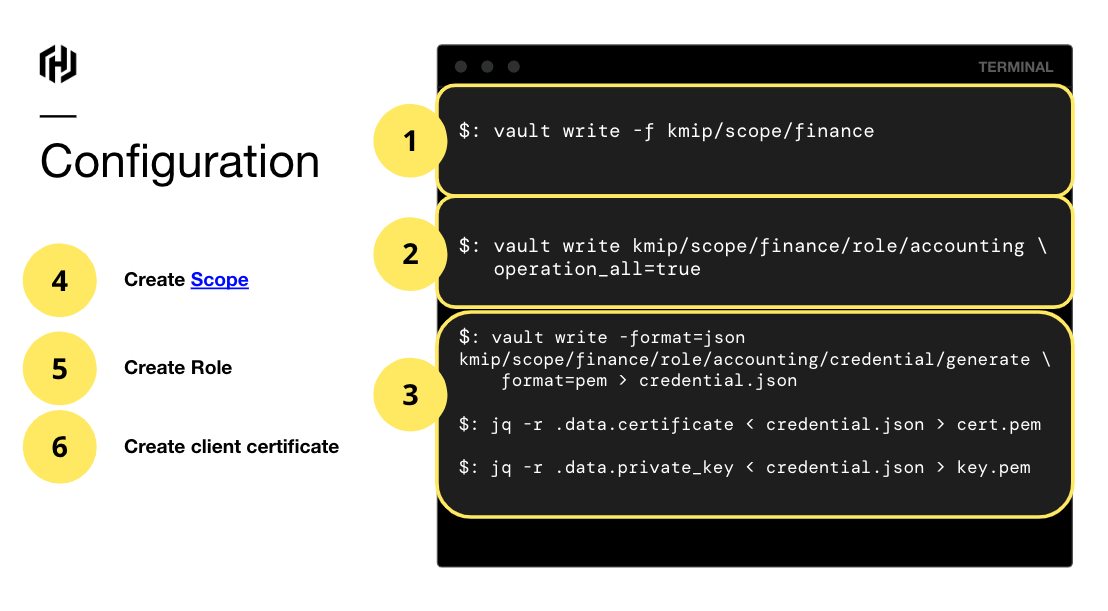

### Settings for the KMIP `scope`

In [ ]:
%%bash
# Create a scope
vault write -f kmip/scope/$KMIP_SVC_NAME
# List scopes and verify the KMIP scope has been created
echo
vault list kmip/scope

### Settings for the KMIP `role` to be created

In [ ]:
%%bash
# Create the KMIP Role (note the TTL if not set, it uses the default Vault token/lease TTL of 768hrs)
vault write kmip/scope/$KMIP_SVC_NAME/role/$KMIP_ROLE_NAME tls_client_key_bits=2048 tls_client_key_type=rsa operation_all=true tls_client_ttl=365d
# List roles and verify the KMIP role has been created
echo
vault list kmip/scope/$KMIP_SVC_NAME/role

In [ ]:
%%bash
# Optional - View the role details
vault read kmip/scope/$KMIP_SVC_NAME/role/$KMIP_ROLE_NAME

## Step 3 - Create the KMIP certificates for MongoDB Encryption at Rest

In [ ]:
%%bash
# Create a folder for the KMIP certificates
mkdir certs

# Save KMIP CA certificate
vault read -format=json kmip/ca | jq -r .data.ca_pem > ./certs/ca.pem    

# Generate the required certificates
vault write -format=json \
  kmip/scope/$KMIP_SVC_NAME/role/$KMIP_ROLE_NAME/credential/generate \
  format=pem > credential.json

# Save the certificate and private key
jq -r .data.certificate < credential.json > ./certs//cert.pem
jq -r .data.private_key < credential.json > ./certs//key.pem
cat ./certs/cert.pem ./certs/key.pem > ./certs/client.pem

# Remove the temp file
rm credential.json

## Step 4 - Configuring MongoDB Enterprise Server with Encryption at Rest

### Start a MongoDB node 

In [ ]:
%%bash
export KMIP_ADDR=$(terraform  output -state=../1_Platform_Deployment/terraform.tfstate -raw cluster_primary_fqdn_kmip)
export FQDN=$(echo "$KMIP_ADDR" | sed -E 's~https://([^:/]+).*~\1~')
export IP=$(dig $FQDN +short)

# Start a MongoDB node 
docker run -d --rm --volume=./certs:/certs -p 27017:27017 --name mongo-enterprise \
mongodb/mongodb-enterprise-server:7.0-ubuntu2204 --port 27017 --bind_ip "0.0.0.0" \
--enableEncryption --kmipServerName $IP --kmipPort $VAULT_KMIP_PORT \
--kmipServerCAFile /certs/ca.pem --kmipClientCertificateFile /certs/client.pem

In [ ]:
# Check that the MongoDB are running
! docker ps

## Step 5 - Testing MongoDB Enterprise Encryption at Rest

In [ ]:
## In a terminal
# Show the contents of MongoDB database data folder
docker exec -it mongo-enterprise sh -c "ls /data/db"

### Create database “record”, insert record with random user details (using function makeid), and display table records

In [ ]:
%%bash
# Create database “record”, insert record with random user details (using function makeid), and display table records
# Note: You can run this multiple times to insert more records as required

# Take note of the username and password values being inserted into the table
mongosh mongodb://127.0.0.1:$MONGODB_PORT/admin --eval "use record" \
--eval "function makeid(length) {
    var result           = '';
    var characters       = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789';
    var charactersLength = characters.length;
    for ( var i = 0; i < length; i++ ) {
      result += characters.charAt(Math.floor(Math.random() * 
 charactersLength));
   }
   return result;
}" \
--eval "db.users.insertOne({username: \"user-\" + makeid(4), password: makeid(20)})" \
--eval "db.users.find()"

In [ ]:
%%bash
# Simulate that the KMIP server is down by changing the listening port to 5697
vault write kmip/config listen_addrs=0.0.0.0:5697

In [ ]:
%%bash
# Reinsert another record and query to show that CRUD operations are still working
mongosh mongodb://127.0.0.1:$MONGODB_PORT/admin --eval "use record" \
--eval "function makeid(length) {
    var result           = '';
    var characters       = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789';
    var charactersLength = characters.length;
    for ( var i = 0; i < length; i++ ) {
      result += characters.charAt(Math.floor(Math.random() * 
 charactersLength));
   }
   return result;
}" \
--eval "db.users.insertOne({username: \"user-\" + makeid(4), password: makeid(20)})" \
--eval "db.users.find()"

In [ ]:
# Flush all data to the storage layer
! mongosh mongodb://127.0.0.1:$MONGODB_PORT/admin --eval "db.adminCommand( { fsync: 1 } )"

In [ ]:
# In a terminal
# Now view the contents of MongoDB database data folder again.  You should notice a new collection file for the data we inserted. 
# It should be named like "collection-7--XXXXXXXXXXXXXXXXXX.wt" collection-7--4848515339651436823.wt 

docker exec -it mongo-enterprise sh -c "ls /data/db"

In [ ]:
# In a terminal
# Dump the contents of the new collections file.
# Notice that the username and password of the inserted record is now encrypted
# Note: MongoDB might take a while to flush the data to the database file.  Wait a while and try again if you do not see any data in the file.

docker exec -it mongo-enterprise sh -c "cat data/db/collection-7*"

# Cleanup

### Disable KMIP secrets engine

In [ ]:
! vault secrets disable kmip

### # Stop MongoDB container and remove certs

In [ ]:
! docker stop mongo-enterprise
! rm -rf certs